# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 100
    
    nodes_cnt = 200

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [5]:
setting = Setting()

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [6]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [7]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [8]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [9]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [10]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [11]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

## Read data

### Load test data

In [13]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [14]:
train, train_bet = load_data(os.path.join(setting.data_train, str(setting.nodes_cnt)))

In [15]:
valid, valid_bet = load_data(os.path.join(setting.data_valid, str(setting.nodes_cnt)))

### Cvt to data/dataloader

In [16]:
train_loader = to_dataloader(train, train_bet, batch=32)
valid_loader = to_dataloader(valid, valid_bet, batch=32)

In [17]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [18]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [19]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [20]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [21]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [22]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [23]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [24]:
import node2vec
from gensim.models import Word2Vec

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [25]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [26]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [27]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [28]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [29]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [30]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [31]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "mse": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "mse": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
#             src = np.random.choice(len(indice), 5*len(indice), replace=True)
#             det = np.random.choice(len(indice), 5*len(indice), replace=True)
#             src = torch.from_numpy(src)
#             det = torch.from_numpy(det)

            
#             y_gt = gt[det] - gt[src]
#             y_pr = pr[det] - pr[src]
            
#             y_gt = nn.Sigmoid()(y_gt)
#             y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.MSELoss()(pr, gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
#                 src = np.random.choice(len(indice), 5*len(indice), replace=True)
#                 det = np.random.choice(len(indice), 5*len(indice), replace=True)
#                 src = torch.from_numpy(src)
#                 det = torch.from_numpy(det)

#                 y_gt = gt[det] - gt[src]
#                 y_pr = pr[det] - pr[src]

#                 y_gt = nn.Sigmoid()(y_gt)
#                 y_pr = nn.Sigmoid()(y_pr)

                loss = nn.MSELoss()(pr, gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["mse"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
#                 src = np.random.choice(len(indice), 5*len(indice), replace=True)
#                 det = np.random.choice(len(indice), 5*len(indice), replace=True)
#                 src = torch.from_numpy(src)
#                 det = torch.from_numpy(det)

#                 y_gt = gt[det] - gt[src]
#                 y_pr = pr[det] - pr[src]

#                 y_gt = nn.Sigmoid()(y_gt)
#                 y_pr = nn.Sigmoid()(y_pr)

                loss = nn.MSELoss()(pr, gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["mse"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 0/313 [00:00<?, ?it/s]


Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 8.262257564022466e-05, top 1 = 0.89415, top 5 = 0.9229899999999092, top 10 = 0.9175999999999476, kendal = 0.7419629638828044


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 7.316653921574443e-05, top 1 = 0.88, top 5 = 0.9110000000000005, top 10 = 0.9085000000000008, kendal = 0.7436207223978731

Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 8.564927381376627e-06, top 1 = 0.9107, top 5 = 0.9366499999999156, top 10 = 0.9353349999999493, kendal = 0.8149949780303551


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 6.380383142945638e-06, top 1 = 0.895, top 5 = 0.9300000000000004, top 10 = 0.9295000000000008, kendal = 0.816709167992809

Epoch: 3


 25%|██▌       | 1/4 [00:00<00:00,  6.84it/s]

Train: loss = 3.1288258099847426e-06, top 1 = 0.93535, top 5 = 0.9500899999999248, top 10 = 0.9449299999999579, kendal = 0.842665644894895


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 2.640777054823678e-06, top 1 = 0.95, top 5 = 0.9440000000000002, top 10 = 0.9465000000000005, kendal = 0.8440589288326376

Epoch: 4


 25%|██▌       | 1/4 [00:00<00:00,  5.78it/s]

Train: loss = 2.553951584800196e-06, top 1 = 0.942, top 5 = 0.9540999999999286, top 10 = 0.9498849999999638, kendal = 0.8563788774801963


  1%|          | 2/313 [00:00<00:19, 15.96it/s]

Valid: loss = 2.3245858903362746e-06, top 1 = 0.95, top 5 = 0.9470000000000003, top 10 = 0.9505000000000008, kendal = 0.8573704869246163

Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 2.455564051426824e-06, top 1 = 0.94595, top 5 = 0.9566199999999307, top 10 = 0.9530999999999693, kendal = 0.8632817824661974


  0%|          | 1/313 [00:00<00:33,  9.22it/s]

Valid: loss = 2.290847665629375e-06, top 1 = 0.95, top 5 = 0.9490000000000003, top 10 = 0.9545000000000008, kendal = 0.8639684792733849

Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 2.2156499395800744e-06, top 1 = 0.94865, top 5 = 0.9585699999999326, top 10 = 0.9555249999999698, kendal = 0.8644405708700585


  1%|          | 2/313 [00:00<00:26, 11.85it/s]

Valid: loss = 2.113977378629794e-06, top 1 = 0.95, top 5 = 0.9500000000000002, top 10 = 0.9555000000000008, kendal = 0.8650066800767662

Epoch: 7


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.8690805151412999e-06, top 1 = 0.9517, top 5 = 0.9608799999999353, top 10 = 0.9577899999999723, kendal = 0.8640999956749703


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.8322120722269885e-06, top 1 = 0.95, top 5 = 0.9530000000000004, top 10 = 0.959500000000001, kendal = 0.8645473868519702

Epoch: 8


 25%|██▌       | 1/4 [00:00<00:00,  5.15it/s]

Train: loss = 1.6465665624671781e-06, top 1 = 0.9551, top 5 = 0.9627299999999388, top 10 = 0.959409999999976, kendal = 0.864323063229334


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6659664853934825e-06, top 1 = 0.945, top 5 = 0.9530000000000003, top 10 = 0.960500000000001, kendal = 0.8643755262423405

Epoch: 9


 25%|██▌       | 1/4 [00:00<00:00,  6.25it/s]

Train: loss = 1.4465235846072867e-06, top 1 = 0.9576, top 5 = 0.9641799999999412, top 10 = 0.9603399999999783, kendal = 0.8643328499574356


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.514798857671114e-06, top 1 = 0.945, top 5 = 0.9550000000000002, top 10 = 0.9610000000000011, kendal = 0.8643162282700108

Epoch: 10


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3033790839101737e-06, top 1 = 0.96005, top 5 = 0.9655299999999432, top 10 = 0.9611949999999783, kendal = 0.8659974954626181


  0%|          | 1/313 [00:00<00:40,  7.76it/s]

Valid: loss = 1.4144280892727286e-06, top 1 = 0.945, top 5 = 0.9560000000000001, top 10 = 0.9605000000000011, kendal = 0.8659845698270362

Epoch: 11


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2269481112636343e-06, top 1 = 0.9606, top 5 = 0.9662099999999441, top 10 = 0.9616699999999788, kendal = 0.8681145809867256


  0%|          | 1/313 [00:00<00:38,  8.12it/s]

Valid: loss = 1.370071456903346e-06, top 1 = 0.945, top 5 = 0.958, top 10 = 0.9605000000000011, kendal = 0.8681956255579695

Epoch: 12


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1733980005432639e-06, top 1 = 0.96225, top 5 = 0.9668899999999451, top 10 = 0.9621749999999789, kendal = 0.8697290153308175


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3308949663540947e-06, top 1 = 0.945, top 5 = 0.9610000000000001, top 10 = 0.962500000000001, kendal = 0.8696569330249876

Epoch: 13


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1390569696146676e-06, top 1 = 0.9626, top 5 = 0.967309999999946, top 10 = 0.9626549999999795, kendal = 0.8711031919659837


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3079721245390214e-06, top 1 = 0.94, top 5 = 0.9610000000000001, top 10 = 0.962500000000001, kendal = 0.8709162303154906

Epoch: 14


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.100033864959493e-06, top 1 = 0.9633, top 5 = 0.9675999999999465, top 10 = 0.9631499999999809, kendal = 0.8725613004311672


  0%|          | 1/313 [00:00<00:34,  9.05it/s]

Valid: loss = 1.2754235804955406e-06, top 1 = 0.94, top 5 = 0.9620000000000002, top 10 = 0.962500000000001, kendal = 0.8723885933114189

Epoch: 15


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.0831818274641648e-06, top 1 = 0.96385, top 5 = 0.9678399999999466, top 10 = 0.9635299999999807, kendal = 0.8735635940697248


  0%|          | 1/313 [00:00<00:39,  7.88it/s]

Valid: loss = 1.2602859901823101e-06, top 1 = 0.94, top 5 = 0.9620000000000002, top 10 = 0.9625000000000011, kendal = 0.8733112071848368

Epoch: 16


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.081395262986921e-06, top 1 = 0.9641, top 5 = 0.9681999999999469, top 10 = 0.9637949999999817, kendal = 0.8738465566938859


  0%|          | 1/313 [00:00<00:35,  8.82it/s]

Valid: loss = 1.2601782118794238e-06, top 1 = 0.94, top 5 = 0.9620000000000002, top 10 = 0.9635000000000011, kendal = 0.8736066852030921

Epoch: 17


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1094400357033484e-06, top 1 = 0.96465, top 5 = 0.9683599999999469, top 10 = 0.9639299999999823, kendal = 0.8743868022723061


  0%|          | 1/313 [00:00<00:48,  6.46it/s]

Valid: loss = 1.293452930642069e-06, top 1 = 0.945, top 5 = 0.9640000000000001, top 10 = 0.9635000000000011, kendal = 0.8741132189017757

Epoch: 18


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1493065055803969e-06, top 1 = 0.96505, top 5 = 0.968469999999947, top 10 = 0.9641999999999827, kendal = 0.8749441368800067


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3380186184734829e-06, top 1 = 0.945, top 5 = 0.9640000000000001, top 10 = 0.9630000000000011, kendal = 0.8746991490298208

Epoch: 19


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1546598901468384e-06, top 1 = 0.96545, top 5 = 0.9688699999999477, top 10 = 0.9644949999999828, kendal = 0.875236538884755


  0%|          | 1/313 [00:00<00:43,  7.23it/s]

Valid: loss = 1.3421907207767163e-06, top 1 = 0.94, top 5 = 0.9650000000000002, top 10 = 0.9635000000000011, kendal = 0.8749222647592272

Epoch: 20


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1819096630931097e-06, top 1 = 0.96565, top 5 = 0.9691199999999477, top 10 = 0.9647249999999838, kendal = 0.8760660844825852


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.36869080528751e-06, top 1 = 0.94, top 5 = 0.9640000000000002, top 10 = 0.9635000000000011, kendal = 0.8758147265152225

Epoch: 21


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1734481925838289e-06, top 1 = 0.9662, top 5 = 0.9696199999999481, top 10 = 0.9650949999999844, kendal = 0.8767817951790418


  0%|          | 1/313 [00:00<00:40,  7.78it/s]

Valid: loss = 1.355306729504757e-06, top 1 = 0.945, top 5 = 0.9650000000000003, top 10 = 0.9635000000000011, kendal = 0.8765142230177989

Epoch: 22


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2010781516163116e-06, top 1 = 0.96635, top 5 = 0.9698399999999483, top 10 = 0.9653899999999838, kendal = 0.8773675640139158


  0%|          | 1/313 [00:00<00:41,  7.51it/s]

Valid: loss = 1.381767433175905e-06, top 1 = 0.94, top 5 = 0.9660000000000002, top 10 = 0.9640000000000011, kendal = 0.8771393472065278

Epoch: 23


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1913360988048863e-06, top 1 = 0.96645, top 5 = 0.9699999999999487, top 10 = 0.9655399999999842, kendal = 0.8777300744495101


  0%|          | 1/313 [00:00<00:39,  7.95it/s]

Valid: loss = 1.3717707278331602e-06, top 1 = 0.94, top 5 = 0.9660000000000002, top 10 = 0.9650000000000012, kendal = 0.8773363311210374

Epoch: 24


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2009769251127802e-06, top 1 = 0.96675, top 5 = 0.9702999999999491, top 10 = 0.9657549999999839, kendal = 0.8788238901241464


  0%|          | 1/313 [00:00<00:39,  7.90it/s]

Valid: loss = 1.3822227996990405e-06, top 1 = 0.94, top 5 = 0.9660000000000002, top 10 = 0.9655000000000011, kendal = 0.8784066824252796

Epoch: 25


 25%|██▌       | 1/4 [00:00<00:00,  5.90it/s]

Train: loss = 1.2038322388620547e-06, top 1 = 0.96695, top 5 = 0.9704799999999494, top 10 = 0.9659449999999846, kendal = 0.8800023782703911


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.384816575817526e-06, top 1 = 0.945, top 5 = 0.9660000000000002, top 10 = 0.9655000000000011, kendal = 0.8795122098614483

Epoch: 26


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2033225135831074e-06, top 1 = 0.96695, top 5 = 0.9706699999999495, top 10 = 0.9662149999999843, kendal = 0.8806071677943628


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.385033238230685e-06, top 1 = 0.945, top 5 = 0.9660000000000002, top 10 = 0.9655000000000011, kendal = 0.8802207522214763

Epoch: 27


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1914367436761372e-06, top 1 = 0.967, top 5 = 0.97083999999995, top 10 = 0.9665499999999844, kendal = 0.8813866797208517


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3738492587171759e-06, top 1 = 0.94, top 5 = 0.9660000000000002, top 10 = 0.9655000000000011, kendal = 0.8810609529234672

Epoch: 28


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1982629162095409e-06, top 1 = 0.9672, top 5 = 0.9712199999999505, top 10 = 0.966774999999984, kendal = 0.8820758579499596


  0%|          | 1/313 [00:00<00:39,  7.95it/s]

Valid: loss = 1.3806793052426033e-06, top 1 = 0.94, top 5 = 0.9680000000000003, top 10 = 0.9655000000000011, kendal = 0.8816699986294015

Epoch: 29


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1911130203835494e-06, top 1 = 0.9675, top 5 = 0.9713699999999508, top 10 = 0.9669749999999847, kendal = 0.8827744676883902


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3745931807141184e-06, top 1 = 0.945, top 5 = 0.9670000000000003, top 10 = 0.9650000000000012, kendal = 0.8823725107629182

Epoch: 30


 25%|██▌       | 1/4 [00:00<00:00,  5.94it/s]

Train: loss = 1.1825979064086067e-06, top 1 = 0.96755, top 5 = 0.971649999999951, top 10 = 0.9671649999999854, kendal = 0.8833498177433948


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3664359655246046e-06, top 1 = 0.945, top 5 = 0.9670000000000003, top 10 = 0.9650000000000012, kendal = 0.8830710033009883

Epoch: 31


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1608220617019144e-06, top 1 = 0.9678, top 5 = 0.9717899999999511, top 10 = 0.9673699999999861, kendal = 0.8837322421326975


  0%|          | 1/313 [00:00<00:47,  6.58it/s]

Valid: loss = 1.3416382332475567e-06, top 1 = 0.945, top 5 = 0.9680000000000003, top 10 = 0.9655000000000011, kendal = 0.8835001493579182

Epoch: 32


 25%|██▌       | 1/4 [00:00<00:00,  6.36it/s]

Train: loss = 1.1545375549999472e-06, top 1 = 0.96795, top 5 = 0.9719499999999515, top 10 = 0.9675249999999865, kendal = 0.8844449033351839


  0%|          | 1/313 [00:00<00:39,  7.95it/s]

Valid: loss = 1.3347958254823729e-06, top 1 = 0.945, top 5 = 0.9680000000000003, top 10 = 0.965000000000001, kendal = 0.8841292951118142

Epoch: 33


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1993127253981876e-06, top 1 = 0.968, top 5 = 0.9720399999999514, top 10 = 0.9676049999999865, kendal = 0.8846014783711753


  0%|          | 1/313 [00:00<00:41,  7.46it/s]

Valid: loss = 1.3799697375398534e-06, top 1 = 0.945, top 5 = 0.9690000000000002, top 10 = 0.965000000000001, kendal = 0.8842609528729617

Epoch: 34


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.201279979236582e-06, top 1 = 0.9682, top 5 = 0.9722499999999514, top 10 = 0.9677899999999873, kendal = 0.8848371367048062


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3800050420253964e-06, top 1 = 0.945, top 5 = 0.9700000000000002, top 10 = 0.965000000000001, kendal = 0.8845725104598842

Epoch: 35


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1974700133432734e-06, top 1 = 0.96835, top 5 = 0.9724199999999524, top 10 = 0.9679549999999868, kendal = 0.8854859128928018


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3751538732768729e-06, top 1 = 0.945, top 5 = 0.9700000000000002, top 10 = 0.9655000000000009, kendal = 0.8852519075205666

Epoch: 36


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.1928987370543677e-06, top 1 = 0.96865, top 5 = 0.9726599999999529, top 10 = 0.9680499999999869, kendal = 0.8861658536682279


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3703170892357486e-06, top 1 = 0.945, top 5 = 0.9710000000000002, top 10 = 0.9660000000000011, kendal = 0.8859906005333529

Epoch: 37


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2193965534988978e-06, top 1 = 0.96865, top 5 = 0.9728099999999528, top 10 = 0.9682499999999878, kendal = 0.8864442580037454


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.3953265538958672e-06, top 1 = 0.95, top 5 = 0.9700000000000002, top 10 = 0.966500000000001, kendal = 0.8862107014146577

Epoch: 38


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2161250059111701e-06, top 1 = 0.96885, top 5 = 0.9728299999999527, top 10 = 0.9684099999999879, kendal = 0.8868110407827651


  0%|          | 1/313 [00:00<00:52,  5.97it/s]

Valid: loss = 1.3889908622636397e-06, top 1 = 0.95, top 5 = 0.9700000000000002, top 10 = 0.966500000000001, kendal = 0.8866629630242245

Epoch: 39


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2324463375055289e-06, top 1 = 0.96885, top 5 = 0.9729699999999529, top 10 = 0.9684899999999872, kendal = 0.8872912205650262


  0%|          | 1/313 [00:00<00:50,  6.23it/s]

Valid: loss = 1.4082548039998315e-06, top 1 = 0.945, top 5 = 0.9690000000000002, top 10 = 0.967000000000001, kendal = 0.8871162291033542

Epoch: 40


 25%|██▌       | 1/4 [00:00<00:00,  5.49it/s]

Train: loss = 1.251782867469185e-06, top 1 = 0.9692, top 5 = 0.9730999999999532, top 10 = 0.9685949999999879, kendal = 0.887823599221419


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.4284126941560273e-06, top 1 = 0.945, top 5 = 0.9700000000000002, top 10 = 0.967000000000001, kendal = 0.8875393446054852

Epoch: 41


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3029007876297138e-06, top 1 = 0.9695, top 5 = 0.973189999999953, top 10 = 0.9686999999999883, kendal = 0.8881595567833367


  0%|          | 1/313 [00:00<00:43,  7.18it/s]

Valid: loss = 1.4825481112000407e-06, top 1 = 0.945, top 5 = 0.9700000000000002, top 10 = 0.968000000000001, kendal = 0.887890098525847

Epoch: 42


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3122600044997461e-06, top 1 = 0.9698, top 5 = 0.9732499999999534, top 10 = 0.968824999999989, kendal = 0.8885758784383458


  0%|          | 1/313 [00:00<00:56,  5.53it/s]

Valid: loss = 1.494456307265942e-06, top 1 = 0.945, top 5 = 0.9700000000000002, top 10 = 0.967000000000001, kendal = 0.8882408522441854

Epoch: 43


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.308284972816085e-06, top 1 = 0.9698, top 5 = 0.9732999999999532, top 10 = 0.9687549999999883, kendal = 0.8888529514834514


  0%|          | 1/313 [00:00<00:52,  5.91it/s]

Valid: loss = 1.489211637749824e-06, top 1 = 0.945, top 5 = 0.9720000000000002, top 10 = 0.968000000000001, kendal = 0.8884237667412905

Epoch: 44


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2846706833891913e-06, top 1 = 0.97005, top 5 = 0.9733099999999535, top 10 = 0.9688049999999879, kendal = 0.8891620034829378


  0%|          | 1/313 [00:00<00:53,  5.88it/s]

Valid: loss = 1.465097315364009e-06, top 1 = 0.945, top 5 = 0.9710000000000002, top 10 = 0.968500000000001, kendal = 0.888718239128353

Epoch: 45


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3425985090977854e-06, top 1 = 0.96985, top 5 = 0.9733199999999536, top 10 = 0.9688849999999879, kendal = 0.8893803943146681


  0%|          | 1/313 [00:00<00:50,  6.17it/s]

Valid: loss = 1.5258491756742798e-06, top 1 = 0.945, top 5 = 0.9710000000000002, top 10 = 0.968500000000001, kendal = 0.8889383398328874

Epoch: 46


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3121744945493895e-06, top 1 = 0.96985, top 5 = 0.9734099999999533, top 10 = 0.9690099999999882, kendal = 0.8897993312991028


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.4943609998099318e-06, top 1 = 0.945, top 5 = 0.9710000000000002, top 10 = 0.968500000000001, kendal = 0.8892890937279964

Epoch: 47


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3491009005970303e-06, top 1 = 0.97005, top 5 = 0.9734399999999536, top 10 = 0.9690949999999884, kendal = 0.8899142548038795


  0%|          | 1/313 [00:00<00:56,  5.56it/s]

Valid: loss = 1.5355058524204642e-06, top 1 = 0.945, top 5 = 0.9710000000000002, top 10 = 0.968500000000001, kendal = 0.889404671617444

Epoch: 48


 25%|██▌       | 1/4 [00:00<00:00,  6.59it/s]

Train: loss = 1.3530189525088236e-06, top 1 = 0.97, top 5 = 0.9736899999999543, top 10 = 0.9692849999999886, kendal = 0.8901633614432977


  0%|          | 1/313 [00:00<00:57,  5.47it/s]

Valid: loss = 1.541006858219221e-06, top 1 = 0.945, top 5 = 0.9710000000000002, top 10 = 0.968500000000001, kendal = 0.8895393458428745

Epoch: 49


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3407285468403055e-06, top 1 = 0.9701, top 5 = 0.9737999999999545, top 10 = 0.9693849999999893, kendal = 0.8903383987822594


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.526977276543958e-06, top 1 = 0.945, top 5 = 0.9720000000000003, top 10 = 0.9690000000000011, kendal = 0.889746381372294

Epoch: 50


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.350839373015029e-06, top 1 = 0.9701, top 5 = 0.9738899999999545, top 10 = 0.9694999999999893, kendal = 0.8904993938328948


  0%|          | 1/313 [00:00<00:52,  6.00it/s]

Valid: loss = 1.5386356931222446e-06, top 1 = 0.945, top 5 = 0.9720000000000003, top 10 = 0.970000000000001, kendal = 0.889923266147944

Epoch: 51


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3589889460000965e-06, top 1 = 0.96995, top 5 = 0.9739999999999547, top 10 = 0.9696699999999897, kendal = 0.890618320685005


  0%|          | 1/313 [00:00<00:43,  7.20it/s]

Valid: loss = 1.547111135945666e-06, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.970000000000001, kendal = 0.8900076885110247

Epoch: 52


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3457995546990772e-06, top 1 = 0.97, top 5 = 0.9739999999999549, top 10 = 0.9696749999999896, kendal = 0.8908075479208817


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5341844206655855e-06, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.969500000000001, kendal = 0.8901845727816187

Epoch: 53


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3568130548044947e-06, top 1 = 0.9703, top 5 = 0.9739999999999549, top 10 = 0.9696949999999895, kendal = 0.8908455267467241


  0%|          | 1/313 [00:00<00:33,  9.25it/s]

Valid: loss = 1.545691339968598e-06, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.970000000000001, kendal = 0.8901976381335045

Epoch: 54


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3449506892391576e-06, top 1 = 0.97025, top 5 = 0.9741399999999548, top 10 = 0.9697949999999899, kendal = 0.8909095345025746


  0%|          | 1/313 [00:00<00:42,  7.38it/s]

Valid: loss = 1.5356160910276308e-06, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.970000000000001, kendal = 0.8902689951699524

Epoch: 55


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3501907604180548e-06, top 1 = 0.97025, top 5 = 0.9740899999999548, top 10 = 0.9698849999999902, kendal = 0.8908814317847016


  0%|          | 1/313 [00:00<01:00,  5.13it/s]

Valid: loss = 1.540119502572043e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.969500000000001, kendal = 0.8902046736124182

Epoch: 56


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3547117159666577e-06, top 1 = 0.9703, top 5 = 0.9741999999999549, top 10 = 0.9699699999999906, kendal = 0.891129469792314


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5469329078771748e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8905765333887042

Epoch: 57


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.356000966578103e-06, top 1 = 0.97045, top 5 = 0.9743399999999548, top 10 = 0.9700399999999907, kendal = 0.8913288588971457


  0%|          | 1/313 [00:00<00:51,  6.01it/s]

Valid: loss = 1.5515053717894876e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9695000000000009, kendal = 0.8907403524589292

Epoch: 58


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3905346800454453e-06, top 1 = 0.9707, top 5 = 0.974439999999955, top 10 = 0.9700799999999908, kendal = 0.891443451897577


  0%|          | 1/313 [00:00<00:39,  7.97it/s]

Valid: loss = 1.590419814220259e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8908438701983856

Epoch: 59


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.4044319107081039e-06, top 1 = 0.97085, top 5 = 0.974489999999955, top 10 = 0.9700649999999911, kendal = 0.8916411001706005


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.609893455863038e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8910679910539292

Epoch: 60


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.400596291256801e-06, top 1 = 0.97085, top 5 = 0.9745799999999556, top 10 = 0.9700799999999914, kendal = 0.8918151805698302


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6069933774494279e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8911745235404759

Epoch: 61


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.4146564072316823e-06, top 1 = 0.9709, top 5 = 0.9745899999999554, top 10 = 0.9701749999999918, kendal = 0.8916579231978546


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.625374228747783e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9705000000000009, kendal = 0.8911102019829414

Epoch: 62


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.411753010698558e-06, top 1 = 0.97085, top 5 = 0.9745999999999554, top 10 = 0.9702749999999918, kendal = 0.8917137802110437


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6241808152596677e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9695000000000009, kendal = 0.8911071867307947

Epoch: 63


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.4176713358844522e-06, top 1 = 0.97075, top 5 = 0.9746099999999552, top 10 = 0.9703399999999921, kendal = 0.8919270544099199


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6347004817215918e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9700000000000009, kendal = 0.8913061815541525

Epoch: 64


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.4165639218020477e-06, top 1 = 0.9709, top 5 = 0.9746599999999557, top 10 = 0.9703699999999923, kendal = 0.8918753603956516


  0%|          | 1/313 [00:00<01:01,  5.11it/s]

Valid: loss = 1.6375643217065877e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9705000000000009, kendal = 0.8912408547442161

Epoch: 65


 25%|██▌       | 1/4 [00:00<00:00,  6.93it/s]

Train: loss = 1.4159601160000725e-06, top 1 = 0.97105, top 5 = 0.9746799999999557, top 10 = 0.9704249999999923, kendal = 0.8919053435639606


  0%|          | 1/313 [00:00<00:54,  5.72it/s]

Valid: loss = 1.640336054893244e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9705000000000009, kendal = 0.8913031661757407

Epoch: 66


 25%|██▌       | 1/4 [00:00<00:00,  5.46it/s]

Train: loss = 1.4051804497889102e-06, top 1 = 0.971, top 5 = 0.9747699999999561, top 10 = 0.9704499999999929, kendal = 0.8919120817466184


  0%|          | 1/313 [00:00<00:38,  8.04it/s]

Valid: loss = 1.6325662719901946e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9700000000000009, kendal = 0.8913584428859376

Epoch: 67


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3877847416032716e-06, top 1 = 0.9712, top 5 = 0.9748399999999561, top 10 = 0.9705249999999934, kendal = 0.8922830241967896


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6185377161873042e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9695000000000009, kendal = 0.8916488945664289

Epoch: 68


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.4262920962172814e-06, top 1 = 0.97105, top 5 = 0.9749099999999564, top 10 = 0.970464999999993, kendal = 0.8922436160166186


  0%|          | 1/313 [00:00<00:33,  9.23it/s]

Valid: loss = 1.6637994799434987e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9695000000000009, kendal = 0.8916006536381798

Epoch: 69


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.4105792670679216e-06, top 1 = 0.9714, top 5 = 0.9749099999999562, top 10 = 0.9705849999999928, kendal = 0.8923574887969431


  0%|          | 1/313 [00:00<00:47,  6.53it/s]

Valid: loss = 1.6515100302268853e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9695000000000009, kendal = 0.891701155923467

Epoch: 70


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3868247176843192e-06, top 1 = 0.9714, top 5 = 0.9749199999999564, top 10 = 0.9706299999999932, kendal = 0.8925414687913873


  0%|          | 1/313 [00:00<00:47,  6.54it/s]

Valid: loss = 1.6275150050115874e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8918961307978386

Epoch: 71


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.4257436677158994e-06, top 1 = 0.9716, top 5 = 0.9748499999999561, top 10 = 0.9706049999999931, kendal = 0.8924739086739557


  0%|          | 1/313 [00:00<00:47,  6.54it/s]

Valid: loss = 1.6739906159860411e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9695000000000009, kendal = 0.8918619594637635

Epoch: 72


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3878228920042565e-06, top 1 = 0.97155, top 5 = 0.9749799999999567, top 10 = 0.9707299999999932, kendal = 0.8926894185030129


  0%|          | 1/313 [00:00<00:47,  6.53it/s]

Valid: loss = 1.6360864024603697e-06, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.9695000000000009, kendal = 0.8920408538351139

Epoch: 73


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3961372112205621e-06, top 1 = 0.97165, top 5 = 0.9750599999999565, top 10 = 0.9707299999999932, kendal = 0.8928274765944653


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6508484201680603e-06, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.9695000000000009, kendal = 0.8921423612970442

Epoch: 74


 25%|██▌       | 1/4 [00:00<00:00,  5.55it/s]

Train: loss = 1.3935744873795906e-06, top 1 = 0.9716, top 5 = 0.9751899999999568, top 10 = 0.9707799999999938, kendal = 0.8928669963641769


  0%|          | 1/313 [00:00<00:34,  9.10it/s]

Valid: loss = 1.6529907106005197e-06, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.9695000000000009, kendal = 0.8921604519513273

Epoch: 75


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3673110830727719e-06, top 1 = 0.97155, top 5 = 0.9752199999999571, top 10 = 0.9708149999999938, kendal = 0.8930782605155726


  0%|          | 1/313 [00:00<00:34,  8.94it/s]

Valid: loss = 1.6288550827166643e-06, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.9690000000000009, kendal = 0.8923313055913639

Epoch: 76


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3740514408621389e-06, top 1 = 0.97145, top 5 = 0.975209999999957, top 10 = 0.9708449999999935, kendal = 0.8932204190476672


  0%|          | 1/313 [00:00<00:43,  7.17it/s]

Valid: loss = 1.637834397292651e-06, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.9695000000000009, kendal = 0.8924408529260117

Epoch: 77


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.36900484078059e-06, top 1 = 0.97145, top 5 = 0.9752499999999571, top 10 = 0.9708949999999933, kendal = 0.8932219869012548


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6352435577238726e-06, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.970000000000001, kendal = 0.8924428632287913

Epoch: 78


 25%|██▌       | 1/4 [00:00<00:00,  5.64it/s]

Train: loss = 1.3363044180636793e-06, top 1 = 0.9716, top 5 = 0.975289999999957, top 10 = 0.970924999999994, kendal = 0.8934497155785653


  0%|          | 1/313 [00:00<00:44,  7.05it/s]

Valid: loss = 1.6029887751621827e-06, top 1 = 0.945, top 5 = 0.9740000000000002, top 10 = 0.970000000000001, kendal = 0.8925363302624412

Epoch: 79


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3383299963255193e-06, top 1 = 0.97165, top 5 = 0.9753199999999571, top 10 = 0.9709649999999942, kendal = 0.8935758942091363


  0%|          | 1/313 [00:00<00:40,  7.66it/s]

Valid: loss = 1.610095151056993e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.970000000000001, kendal = 0.8926961293079213

Epoch: 80


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3170634943219176e-06, top 1 = 0.972, top 5 = 0.9753499999999574, top 10 = 0.9710999999999945, kendal = 0.8938352276560668


  0%|          | 1/313 [00:00<00:31,  9.93it/s]

Valid: loss = 1.5908281415992627e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9690000000000009, kendal = 0.8928991442065286

Epoch: 81


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3268318207723767e-06, top 1 = 0.97165, top 5 = 0.9754499999999574, top 10 = 0.9710699999999948, kendal = 0.8938660897628228


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6081617934914211e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.969500000000001, kendal = 0.8930710033009881

Epoch: 82


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3377651790877796e-06, top 1 = 0.9717, top 5 = 0.9754799999999572, top 10 = 0.9711299999999943, kendal = 0.894035563814275


  0%|          | 1/313 [00:00<00:31,  9.97it/s]

Valid: loss = 1.6204325983099114e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.969500000000001, kendal = 0.8931875861398028

Epoch: 83


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.3206210999052367e-06, top 1 = 0.9718, top 5 = 0.9755299999999574, top 10 = 0.9711649999999945, kendal = 0.8942524214251495


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.6072956202556e-06, top 1 = 0.955, top 5 = 0.9730000000000003, top 10 = 0.969500000000001, kendal = 0.8932870835767336

Epoch: 84


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.305405690044895e-06, top 1 = 0.97195, top 5 = 0.9755999999999574, top 10 = 0.9712099999999942, kendal = 0.8942777155613905


  0%|          | 1/313 [00:00<00:52,  5.93it/s]

Valid: loss = 1.5947810222551002e-06, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.969500000000001, kendal = 0.8933101990031063

Epoch: 85


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.303799155467595e-06, top 1 = 0.97185, top 5 = 0.9756299999999574, top 10 = 0.9712449999999939, kendal = 0.8943684057977989


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5925518106031094e-06, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.969500000000001, kendal = 0.8933313046822614

Epoch: 86


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2851737503966582e-06, top 1 = 0.9718, top 5 = 0.9757399999999574, top 10 = 0.9712099999999944, kendal = 0.8945055547596444


  0%|          | 1/313 [00:00<00:45,  6.85it/s]

Valid: loss = 1.5723610671620036e-06, top 1 = 0.945, top 5 = 0.9720000000000003, top 10 = 0.969500000000001, kendal = 0.8934740184268708

Epoch: 87


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2935459497260194e-06, top 1 = 0.97215, top 5 = 0.9757399999999574, top 10 = 0.971259999999994, kendal = 0.8945574063283104


  0%|          | 1/313 [00:00<00:38,  8.00it/s]

Valid: loss = 1.5902288668655558e-06, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.9690000000000011, kendal = 0.8934699981748507

Epoch: 88


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2750352735079087e-06, top 1 = 0.9719, top 5 = 0.9757799999999576, top 10 = 0.9712849999999944, kendal = 0.8946197982643762


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.572986540401728e-06, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.969500000000001, kendal = 0.8934830632489554

Epoch: 89


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2574806280797253e-06, top 1 = 0.9718, top 5 = 0.9758999999999576, top 10 = 0.9713099999999942, kendal = 0.894751387273174


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5558385345832822e-06, top 1 = 0.945, top 5 = 0.9720000000000003, top 10 = 0.9690000000000011, kendal = 0.8935865811146768

Epoch: 90


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2702492417258883e-06, top 1 = 0.9721, top 5 = 0.9759299999999579, top 10 = 0.9713299999999945, kendal = 0.8947988736195391


  0%|          | 1/313 [00:00<00:38,  8.02it/s]

Valid: loss = 1.5728200621304947e-06, top 1 = 0.945, top 5 = 0.9720000000000003, top 10 = 0.969500000000001, kendal = 0.8936348225732352

Epoch: 91


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2564220870610837e-06, top 1 = 0.97205, top 5 = 0.9759599999999579, top 10 = 0.9713699999999946, kendal = 0.8951208636071692


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5605725257296932e-06, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.969500000000001, kendal = 0.8939122092806331

Epoch: 92


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.268358522798448e-06, top 1 = 0.97205, top 5 = 0.9760799999999579, top 10 = 0.9713749999999943, kendal = 0.895342708390855


  0%|          | 1/313 [00:00<00:49,  6.34it/s]

Valid: loss = 1.5780414531459862e-06, top 1 = 0.945, top 5 = 0.9730000000000003, top 10 = 0.9690000000000011, kendal = 0.8941122094321503

Epoch: 93


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2654201479192363e-06, top 1 = 0.9723, top 5 = 0.9760799999999578, top 10 = 0.971359999999994, kendal = 0.8952429060561111


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5775212442179586e-06, top 1 = 0.955, top 5 = 0.9720000000000003, top 10 = 0.9690000000000011, kendal = 0.8939906008363863

Epoch: 94


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2624464174946824e-06, top 1 = 0.9723, top 5 = 0.9761299999999581, top 10 = 0.9713549999999946, kendal = 0.8953839916014327


  0%|          | 1/313 [00:00<00:40,  7.79it/s]

Valid: loss = 1.578020597535387e-06, top 1 = 0.95, top 5 = 0.9720000000000003, top 10 = 0.968000000000001, kendal = 0.8941343190758118

Epoch: 95


 25%|██▌       | 1/4 [00:00<00:00,  7.22it/s]

Train: loss = 1.2434381171075106e-06, top 1 = 0.97235, top 5 = 0.9761799999999581, top 10 = 0.9714149999999947, kendal = 0.8955576799656053


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5587625397644434e-06, top 1 = 0.955, top 5 = 0.9740000000000002, top 10 = 0.968500000000001, kendal = 0.8942368313103389

Epoch: 96


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2322822490616042e-06, top 1 = 0.9724, top 5 = 0.9760399999999577, top 10 = 0.9714249999999948, kendal = 0.8957181478514905


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.550167742931432e-06, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.968500000000001, kendal = 0.8944217558071896

Epoch: 97


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.232384867677468e-06, top 1 = 0.97235, top 5 = 0.976149999999958, top 10 = 0.9715049999999945, kendal = 0.8957156845751247


  0%|          | 1/313 [00:00<00:54,  5.68it/s]

Valid: loss = 1.5497638678652396e-06, top 1 = 0.95, top 5 = 0.9740000000000002, top 10 = 0.9690000000000011, kendal = 0.8943976349263937

Epoch: 98


  0%|          | 0/4 [00:00<?, ?it/s]

Train: loss = 1.2268344461994664e-06, top 1 = 0.97235, top 5 = 0.9761299999999578, top 10 = 0.9715399999999942, kendal = 0.8958892198833007


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5486230818907912e-06, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.968500000000001, kendal = 0.8945554238206117

Epoch: 99


 25%|██▌       | 1/4 [00:00<00:00,  5.21it/s]

Train: loss = 1.2224146246683423e-06, top 1 = 0.97235, top 5 = 0.9762899999999581, top 10 = 0.9715149999999944, kendal = 0.8958561780522434


  0%|          | 0/313 [00:00<?, ?it/s]

Valid: loss = 1.5438931531205739e-06, top 1 = 0.95, top 5 = 0.9730000000000003, top 10 = 0.9690000000000011, kendal = 0.8945634641983868

Epoch: 100


 25%|██▌       | 1/4 [00:00<00:00,  5.09it/s]

Train: loss = 1.210944009233421e-06, top 1 = 0.9723, top 5 = 0.976269999999958, top 10 = 0.9715449999999944, kendal = 0.8960581501479173


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

Valid: loss = 1.5354300140836837e-06, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.9680000000000011, kendal = 0.8947775344996401


# Test

In [32]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
#             src = np.random.choice(len(indice), 5*len(indice), replace=True)
#             det = np.random.choice(len(indice), 5*len(indice), replace=True)
#             src = torch.from_numpy(src)
#             det = torch.from_numpy(det)

#             y_gt = gt[det] - gt[src]
#             y_pr = pr[det] - pr[src]

#             y_gt = nn.Sigmoid()(y_gt)
#             y_pr = nn.Sigmoid()(y_pr)

            loss = nn.MSELoss()(pr, gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [33]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 30/30 [00:13<00:00,  2.30it/s]

Top1: mean=0.93, std=0.02
Top5: mean=0.87, std=0.02
Top10: mean=0.84, std=0.02
Kendal: mean=0.65, std=0.02
Time: mean=0.41, std=0.03
Loss: mean=0.00, std=0.00


In [34]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:32<00:00, 92.87s/it]


Top1: mean=0.63, std=0.00
Top5: mean=0.58, std=0.00
Top10: mean=0.52, std=0.00
Kendal: mean=0.23, std=0.00
Time: mean=92.11, std=0.00
Loss: mean=31792494832867624.00, std=0.00


# Visualization

In [35]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-21 04-04'

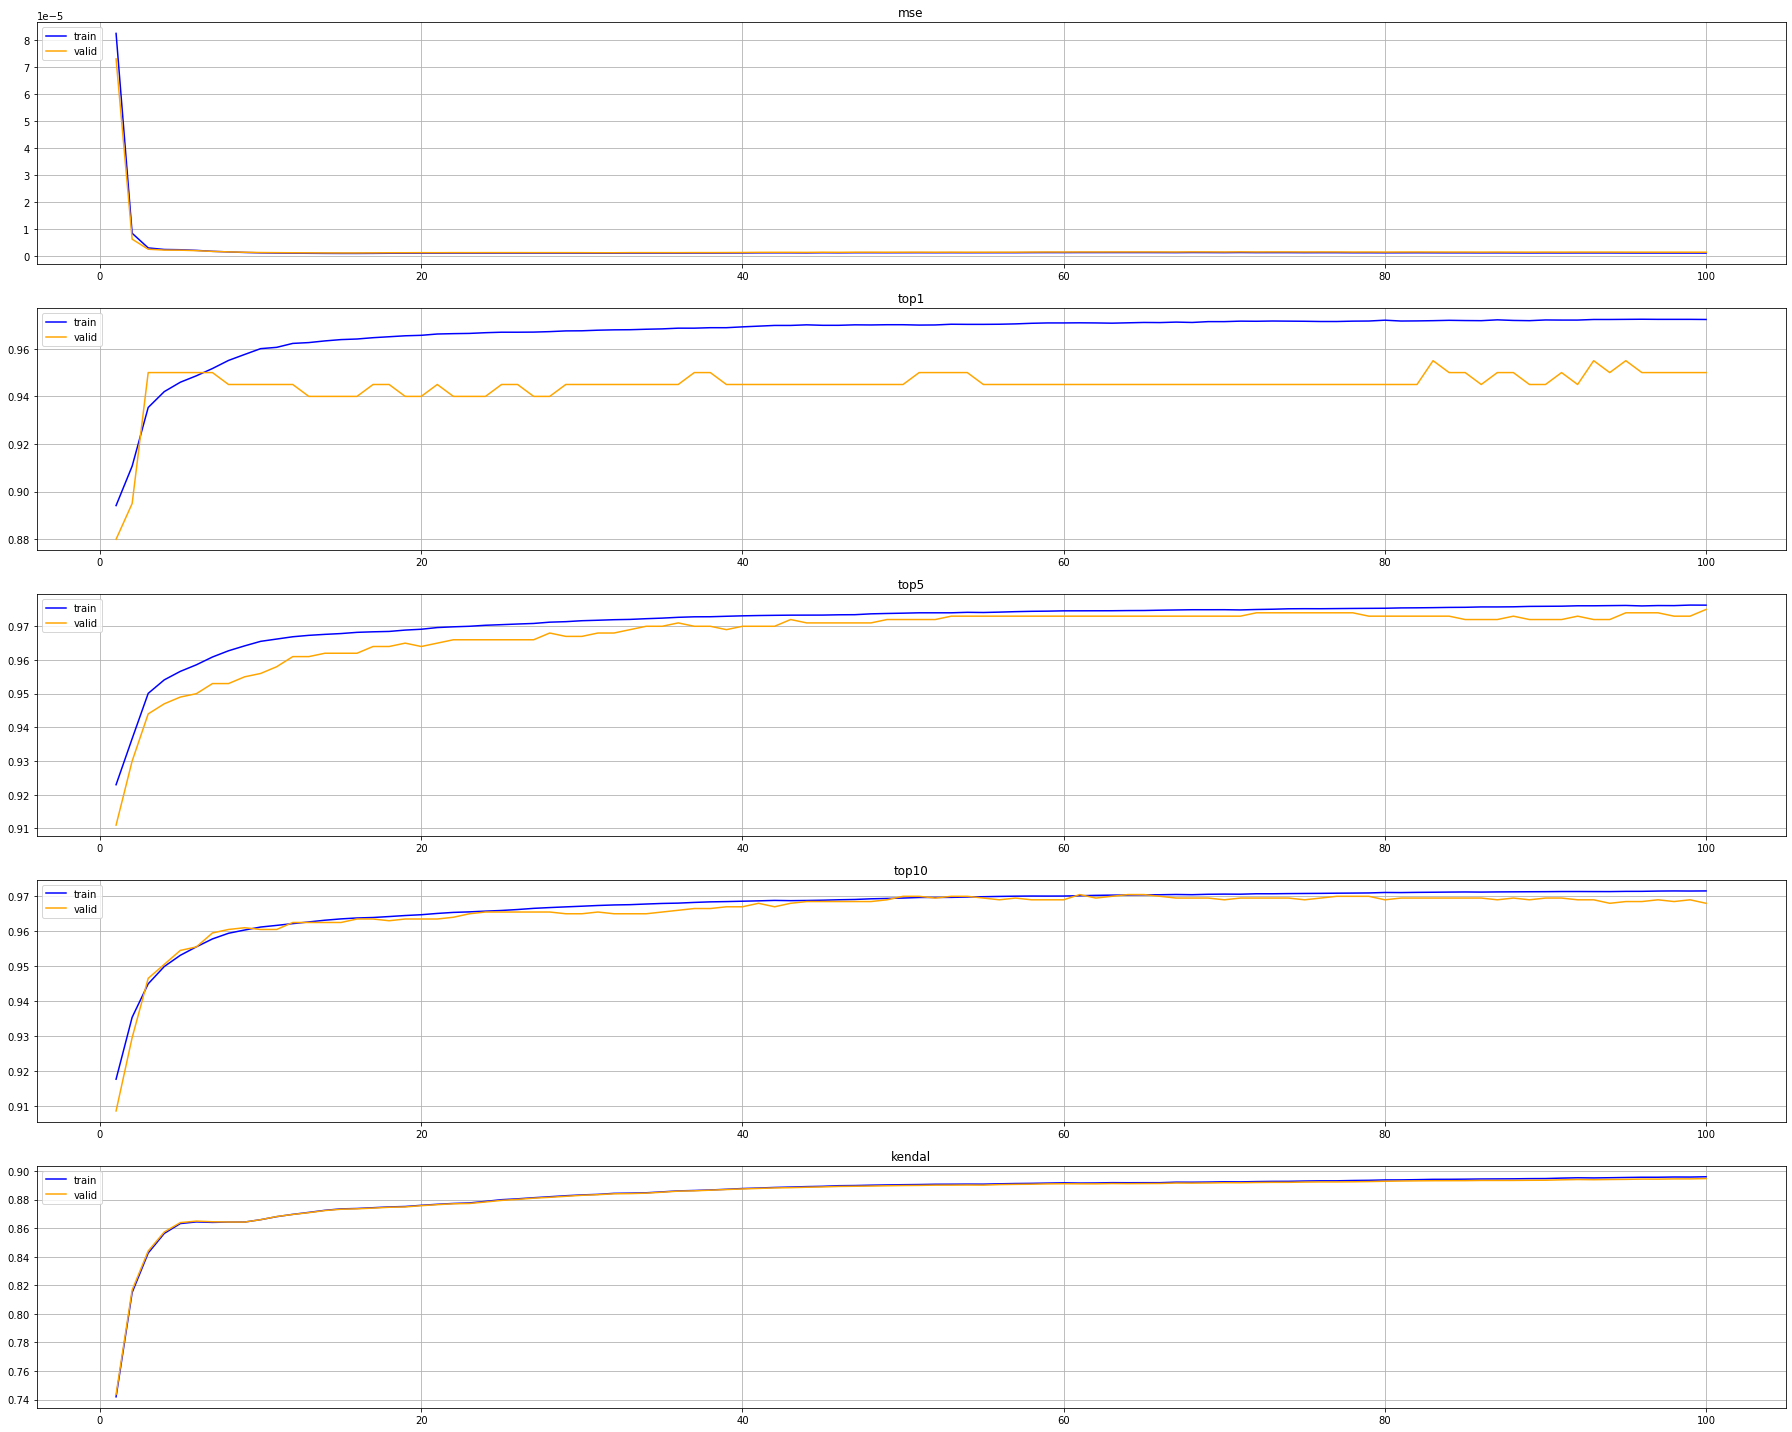

In [37]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]

        ax.plot(x, train[key], color="blue")
        ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [ ]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

In [ ]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    